In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
import os

/Users/cram/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
connection_string = 'postgresql://cram@localhost:5432/ordergrid'

engine = create_engine(connection_string, client_encoding='utf8')

real = pd.read_sql_query(f"""
        select "createdAt"::date as "demandDate",sku, warehouse as "storeLocationId", sum(qty) qty from items_datasets
        GROUP BY "demandDate", "storeLocationId", sku """,con=engine)

real.tail()

,demandDate,sku,storeLocationId,qty
2302488,2022-10-20,TTGS-21,TOR-01,8
2302489,2022-10-20,TTHF-21,TOR-01,8
2302490,2022-10-20,TTMM-21,TOR-01,1
2302491,2022-10-20,TTMMASK,TOR-01,1
2302492,2022-10-20,TTSO-21,TOR-01,7


In [3]:
real['demandDate'] = pd.to_datetime(real['demandDate'])

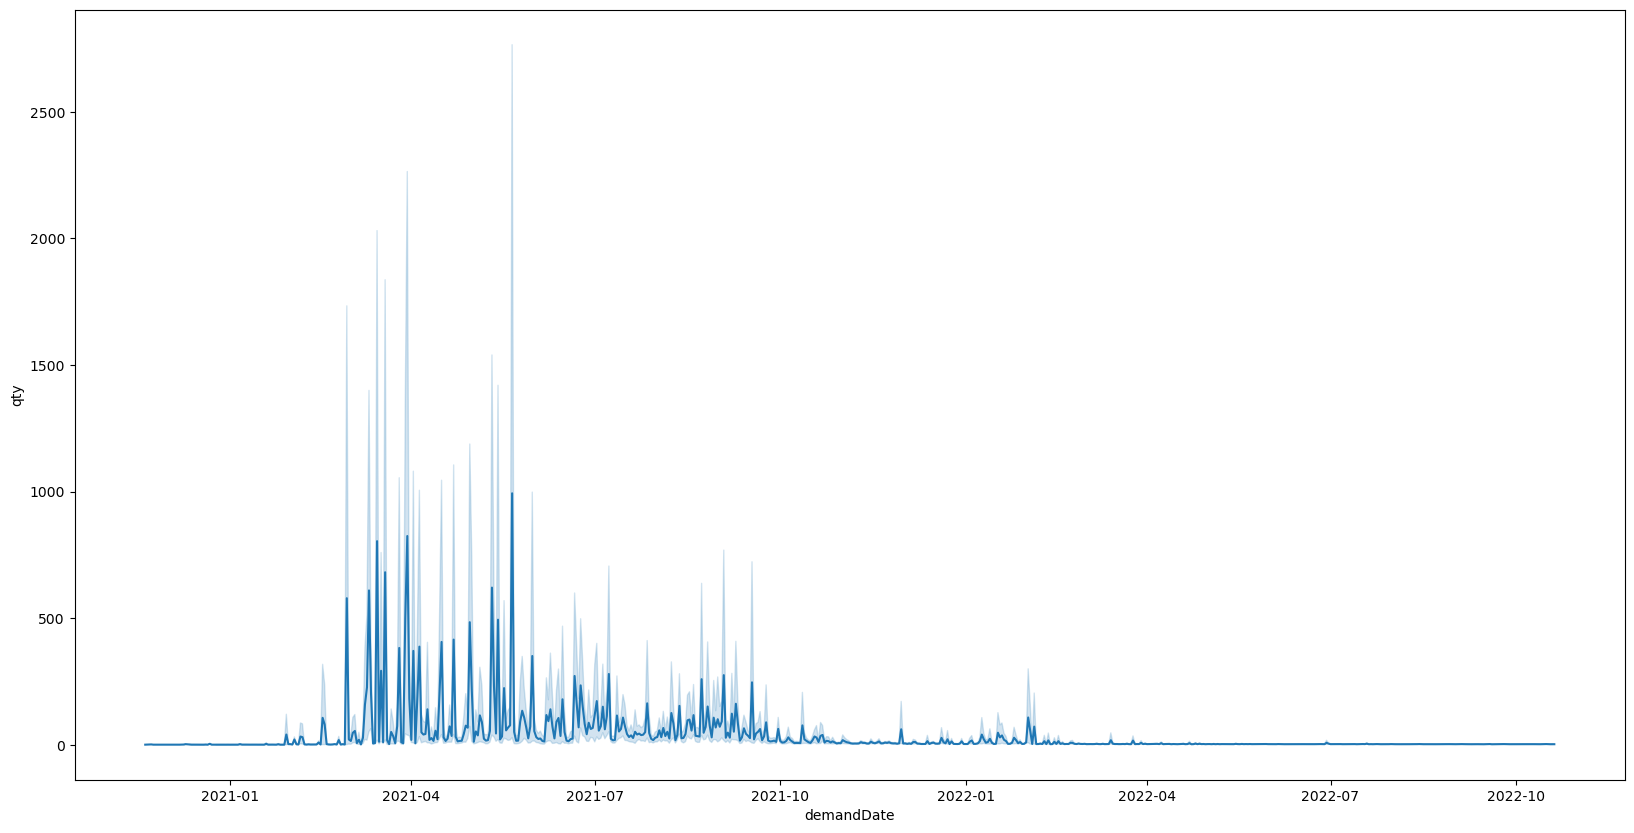

In [4]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(data=real, x="demandDate", y="qty")

In [30]:
forecast = pd.read_csv('/Users/cram/PycharmProjects/University/demand_forecast.csv')

In [31]:
forecast['total_demand'] = forecast['systemDemand'] + forecast['safetyStock']
forecast['demandDate'] = pd.to_datetime(forecast['demandDate'])

In [32]:
forecast = forecast.groupby(['storeLocationId','demandDate','sku'], as_index=False).agg({'total_demand': 'sum'})

In [33]:
forecast.head()

,storeLocationId,demandDate,sku,total_demand
0,00001,2022-10-21,1286,0.0
1,00001,2022-10-21,1289,0.0
2,00001,2022-10-21,1292,0.0
3,00001,2022-10-21,1295,0.0
4,00001,2022-10-21,1303,0.0


In [34]:
uniq_wh = forecast.storeLocationId.unique()
real = real.loc[real['storeLocationId'].isin(uniq_wh)]

In [44]:
real = real.rename(columns = {'qty':'total_demand'})

df_all = pd.concat([real.groupby(['storeLocationId','demandDate'], as_index=False).agg({'total_demand': 'sum'}).assign(Measure='real'), forecast.groupby(['storeLocationId','demandDate'], as_index=False).agg({'total_demand': 'sum'}).assign(Measure='forecast')])
df_all = df_all[['storeLocationId','demandDate', 'total_demand', 'Measure']].reset_index(drop = True)

df_all['demandDate'] = pd.to_datetime(df_all['demandDate']).dt.date
df_all.head()

,storeLocationId,demandDate,total_demand,Measure
0,00001,2022-05-20,18.0,real
1,00001,2022-05-24,17.0,real
2,00001,2022-05-25,339.0,real
3,00001,2022-05-26,568.0,real
4,00001,2022-05-27,446.0,real


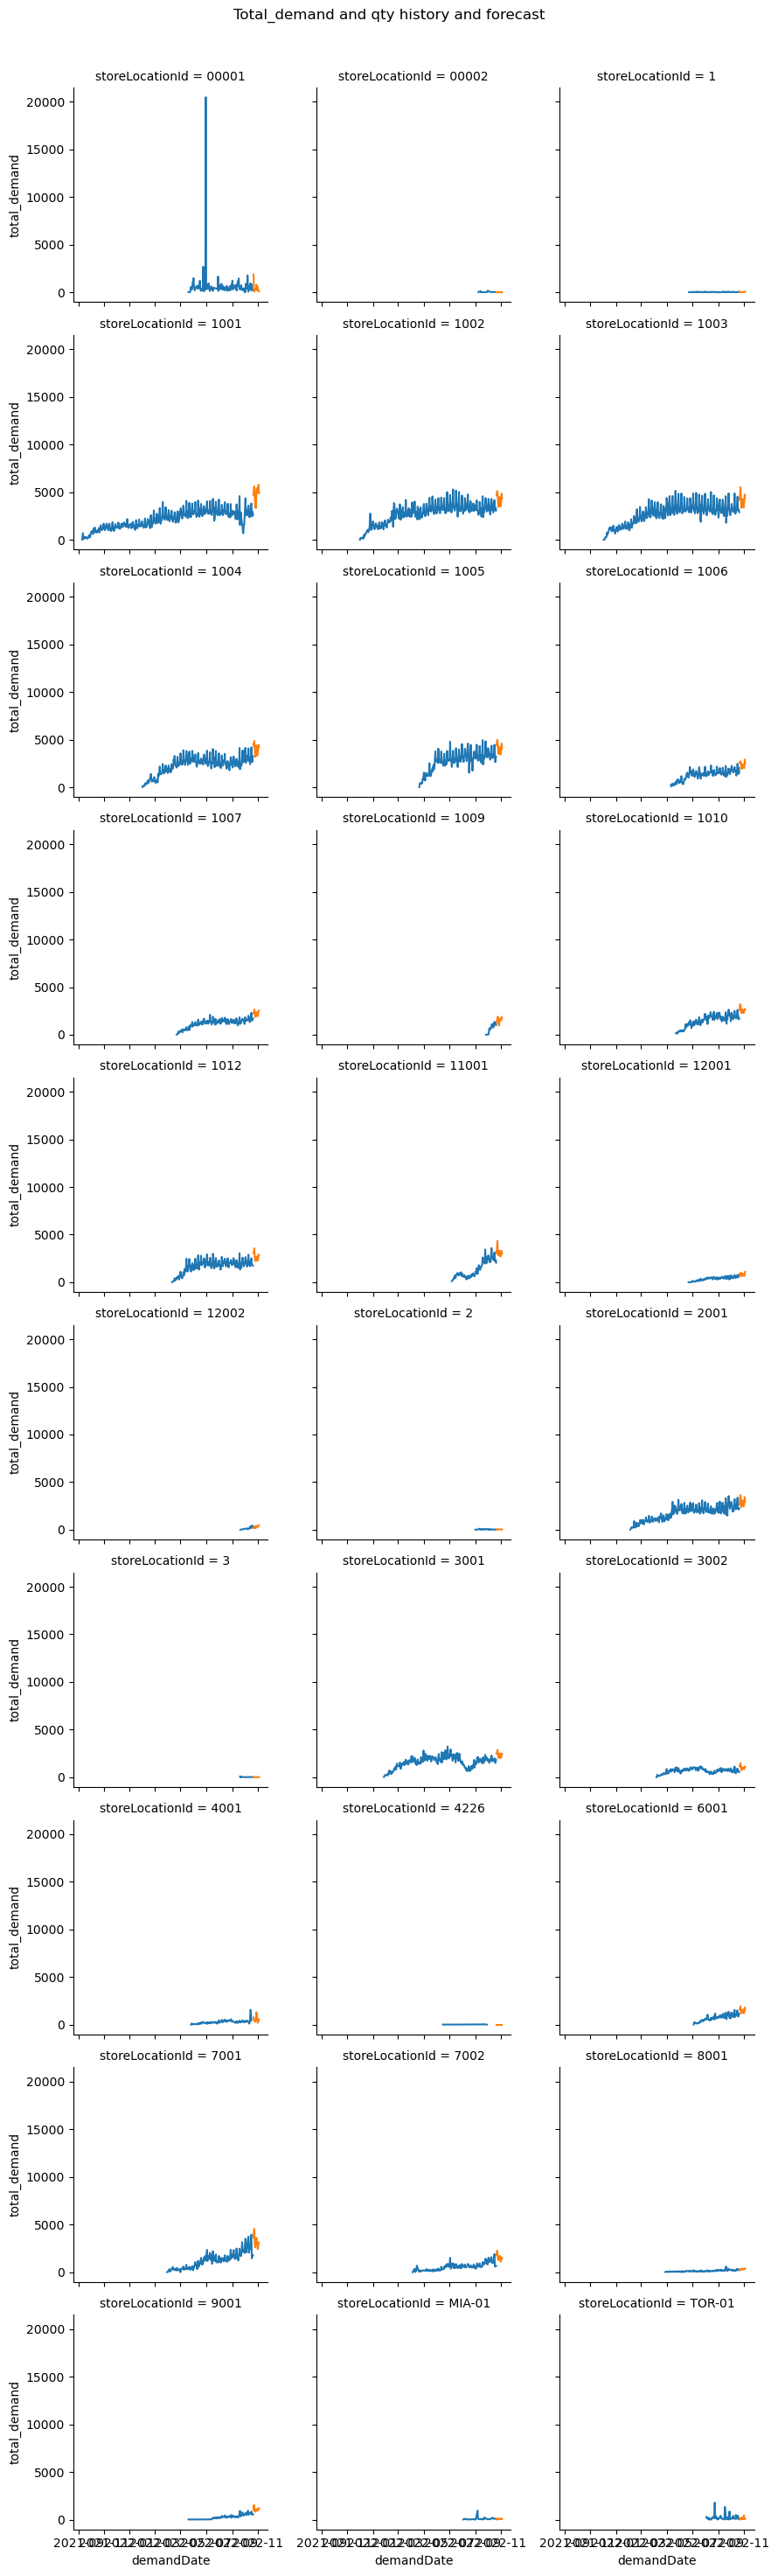

In [45]:
g = sns.FacetGrid(df_all, col="storeLocationId", hue="Measure", col_wrap=3)
g.map(sns.lineplot, "demandDate", "total_demand")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Total_demand and qty history and forecast')
g.savefig('plots.pdf')

In [6]:
MAE = [0.7623, 0.7269, 0.6846, 0.6789, 0.6797, 0.6672,0.6630,0.6563,0.6562]
RMSE = [2.522, 2.293, 2.183, 2.150, 2.212, 2.059, 2.056, 2.014, 1.982]

errors = pd.DataFrame({'MAE' : MAE, 'RMSE': RMSE}).reset_index()

In [7]:
errors

,index,MAE,RMSE
0,0,0.7623,2.522
1,1,0.7269,2.293
2,2,0.6846,2.183
3,3,0.6789,2.150
4,4,0.6797,2.212
5,5,0.6672,2.059
6,6,0.6630,2.056
7,7,0.6563,2.014
8,8,0.6562,1.982


[Text(0.5, 1.0, 'MAE')]

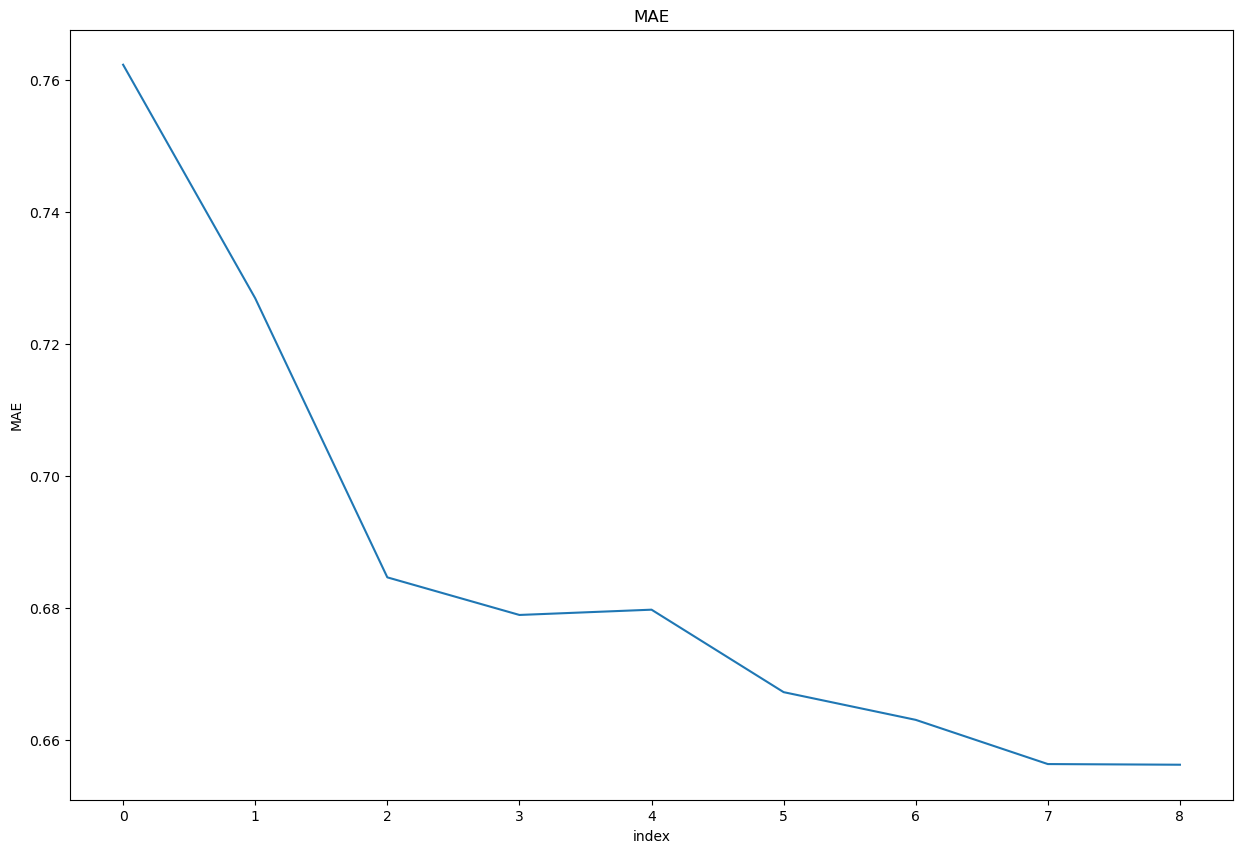

In [10]:
plt.figure(figsize=(15,10))
sns.lineplot(data=errors, x="index", y="MAE").set(title='MAE')

[Text(0.5, 1.0, 'RMSE')]

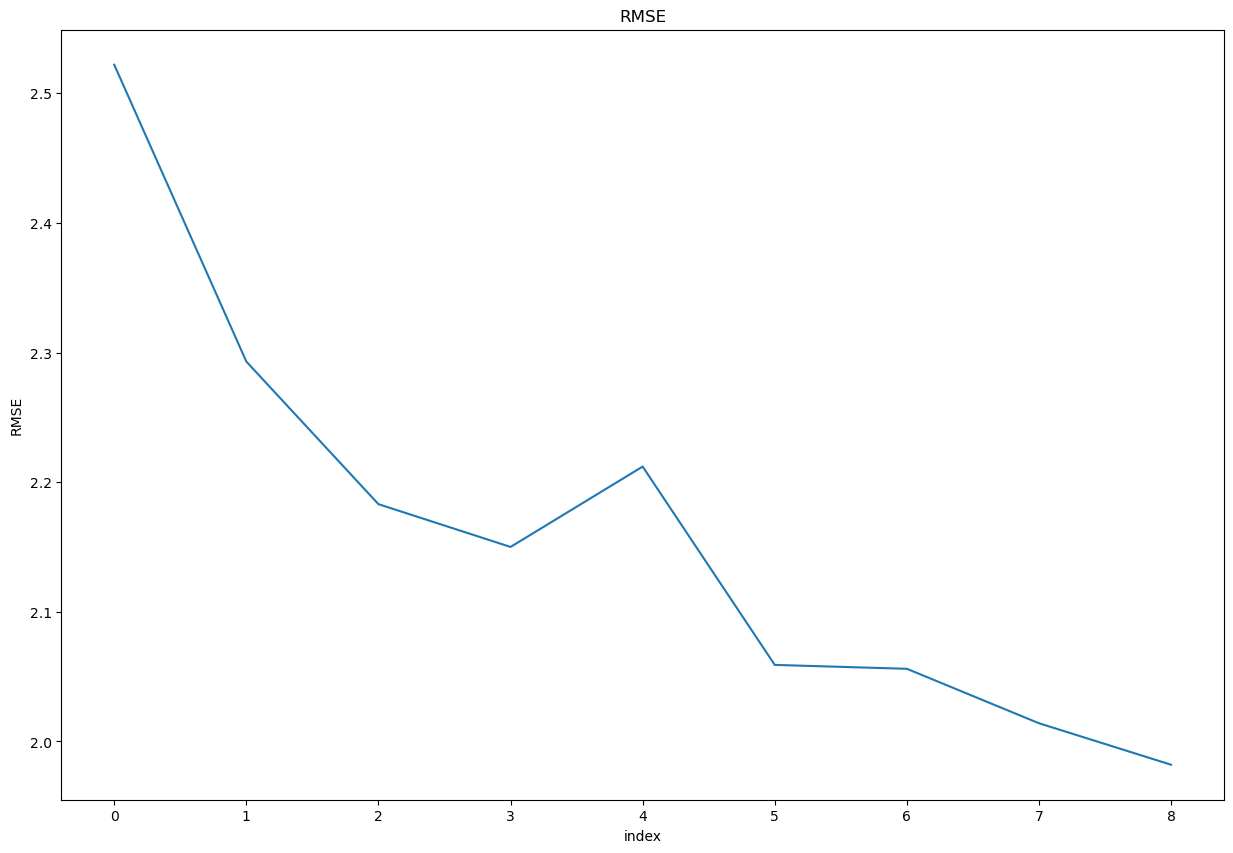

In [11]:
plt.figure(figsize=(15,10))
sns.lineplot(data=errors, x="index", y="RMSE").set(title='RMSE')